<a href="https://colab.research.google.com/github/lgribeiro/Optical_scanner_recognition_OpenCV/blob/main/mark_recognition_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract as ocr

#alogrithm for sorting points clockwise
def clockwise_sort(x):
    return (np.arctan2(x[0] - mx, x[1] - my) + 0.5 * np.pi) % (2*np.pi)

image = cv2.imread('mac2166-t8.PDF-page-001-000.pbm') # [0:1000, 0:1000]
# cv2_imshow(image)
# print("shape", image.shape)



Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [221]:
class preProcessing:
    def __init__(self):
      self.img = None
      self.shape = None
      self.len_quad = 150 
      self.kernel = np.ones((3,3),np.uint8)      

    def resize(self, img):
        ratio = len(img[0]) / 1000.0
        self.img = cv2.resize(img, (0,0), fx=1/ratio, fy=1/ratio)
        
        self.shape = self.img.shape
        print("resize", self.shape)
        return self.img

    def gray(self, img):
        # cv2_imshow(img)
        #gray and filter the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    def bilateralFilter(self, img):
        #bilateral filtering removes noise and preserves edges
        img = cv2.bilateralFilter(img, 11, 17, 17)
        # cv2_imshow(img)
        return img

    def blur(self, img):
        # Blur
        img = cv2.blur(img, (3,3))
        # cv2_imshow(img)
        return img

    def gaussian_blur(self, img):
        img = cv2.GaussianBlur(img, (7, 7), 0)
        return img

    def thresh_binary(self, img):
        (T, img) = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY_INV)
        # cv2_imshow(threshInv)
        return img

    def erode(self, img):
        img = cv2.erode(img,self.kernel,iterations = 1)
        # cv2_imshow(erode)
        return img

    def dilate(self, img):
        img = cv2.dilate(img,self.kernel,iterations = 1)
        # cv2_imshow(dilation)
        return img

    def opening(self, img):
        # # Opening - It is just another name of erosion followed by dilation. 
        # # It is useful in removing noise, as we explained above. Here we use the function, cv2.morphologyEx()
        img = cv2.morphologyEx(erode, cv2.MORPH_OPEN, self.kernel)
        # cv2_imshow(opening)
        return img

    def closing(self, img):
        closing = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, self.kernel)
        # cv2_imshow(closing)
        return img

    def gradient(self, img):
        # # Morphological Gradient - It is the difference between dilation and erosion of an image.
        img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, self.kernel)
        # cv2_imshow(gradient)
        return img

    def otsu(self, img):
        # OTSU
        ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
        # cv2_imshow( img)
        return img

    def laplacian(self, img):
        # Laplacian Derivatives
        img = cv2.Laplacian(img,cv2.CV_64F)
        # cv2_imshow(img_laplacian)
        return img

    def quadrants(self):
        # crop quadrants of image
        # print("resize", self.shape)
        h, w, _ = self.shape
        t = self.len_quad
        # roi = img[y1:y2, x1:x2]
        q1 = img[0:t  ,   0:t].copy() 
        q2 = img[0:t  , w-t:w].copy()
        q3 = img[h-t:h,   0:t].copy()
        q4 = img[h-t:h, w-t:w].copy() 
        # Detecting blobs. 
        # cv2_imshow(q1)
        return [q1, q2, q3, q4]

    def mount(self, quads):
        # fix points in image due the tranformation image in quadrants
        if len(quads)>1:
            point_rect = []
            t = self.len_quad
            # print("resize", self.shape)
            h, w = self.shape[:2]
            for n, q in enumerate(quads):
                if n==0:
                    point_rect.append((q[0]     , q[1]     ))
                elif n==1:    
                    point_rect.append((q[0]+w-t , q[1]     ))
                elif n==2:
                    point_rect.append((q[0]     , q[1]+h-t ))
                elif n==3:
                    point_rect.append((q[0]+w-t , q[1]+h-t ))
        return point_rect


In [222]:
def list_points(keypoints):
    found=[]
    pts=[]
    radius=[]
    for n, keypoint in enumerate(keypoints):
    # find largest blob
        if len(keypoint) > 0:
            # print(keypoints)
            kp_max = keypoint[0]
            for kp in keypoint:
                if kp.size > kp_max.size:
                    kp_max = kp                    
            point_found = n
            point_x = kp_max.pt[0]
            point_y = kp_max.pt[1]
            point_radius = kp_max.size
            # print(point_found, point_x, point_y, point_radius, kp_max)
            found.append(point_found)
            pts.append( [point_x, point_y])
            radius.append(point_radius)

    return found, pts, radius

In [223]:
import math

def rotate_img(points, img):
    # calculate for distance and angle arct


    return

def convert_pts_to_keypoints(pts, sizes): 
    kps = []
    if pts is not None:
        kps = [ cv2.KeyPoint(p[0], p[1], _size=size) for p, size in zip(pts,sizes) ]

    return kps 
def draw_rects(points, sizes, img):
    # draw keypoints
    rect_keypoints = convert_pts_to_keypoints(points, sizes)
    img_rect = cv2.drawKeypoints(img, rect_keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # draw rectangle
    if (points[0] and points[3]):
        img_rect1 = cv2.rectangle(img_rect, (int(points[0][0]), int(points[0][1])), (int(points[3][0]), int(points[3][1])), (200,100,0), 2) 
        # cv2_imshow(img_rect)
    elif (points[1] and points[2]):
        img_rect1 = cv2.rectangle(img_rect, (int(points[1][0]), int(points[1][1])), (int(points[2][0]), int(points[2][1])), (100,200,0), 2)
        # cv2_imshow(img_rect1)
    return img_rect

def distance(centers):
    length= []
    for (i, j) in zip(range(4), [1, 2, 3, 0]):
        length.append(math.sqrt( ((centers[i][0]-centers[j][0])**2)+((centers[i][1]-centers[j][1])**2) ))
        # print('Length of side {}: {}'.format(i+1, length[i]))
    return length

def nusp_rect(W, pts, img):
    '''
    Input
      W: referencial line
      pts: coord  initial (0,0)
      img: image 
    returns
      points: coord nusp rectangle
      img_nusp: image with drawed nusp rectangule
    '''
    # print(pts)
    points = []    
    # Corner top left → 
    points.append((W*0.0457+pts[0], W*0.112+pts[1]))
    # Corner down right → 
    points.append((W*0.2484+pts[0], W*0.4049+pts[1]))

    img = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (100,200,0), 1)
    # cv2_imshow(img)

    return points, img

def nusp_sub_rect (W, pts, img, mode=1):
    points = []
    w_px = W*0.00607
    y_px = W*0.0102
    l_px = W*0.02
    dy  = 0
    c = 0 
    for j in range(20):
        dw  = 0
        if j > 0:
            dy += l_px + y_px
        
        for i in range(8):
            if i > 0:
                dw += l_px + w_px
                             
            points.append((dw + pts[0]       , dy + pts[1]))
            points.append((dw + l_px + pts[0], dy + l_px + pts[1]))
            
            if c%2==0:
                img = cv2.rectangle(img, (int(points[c][0]), int(points[c][1])), (int(points[c+1][0]), int(points[c+1][1])), (200,50,0), 1)
            c += 1
    return points, img

def code_rect(W, pts, img):
    '''
    Input
      W: referencial line
      pts: coord  initial (0,0)
      img: image 
    returns
      points: coord for exam code rectangle
      n_cod2: image with drawed exam code rectangule
    '''
    points = []
    # Retângulo vermelho superior
    # Canto superior esquerdo →
    points.append((W*0.258+pts[0], W*(-0.0434)+pts[1]))
    # Canto inferior direito → 
    points.append((W*0.473+pts[0], W*(-0.025)+pts[1]))

    # Retângulo vermelho inferior:
    # Canto superior esquerdo →
    points.append((W*0.258+pts[0], W*(-0.02075)+pts[1]))
    # Canto inferior direito → 
    points.append((W*0.473+pts[0], W*(-0.0031)+pts[1]))

    img = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (0,0,210), 1)
    img = cv2.rectangle(img, (int(points[2][0]), int(points[2][1])), (int(points[3][0]), int(points[3][1])), (0,0,210), 1)
    # cv2_imshow(n_cod2)

    return points, img

def code_sub_rect (W, pts, img, mode=1):
    points1 = []
    points2 = []
    print(pts)
    print(pts[2][1])
    w_px = W*0.0029
    l_px = W*0.015

    dw = 0
    for i in range(24):                          
        points1.append((dw + pts[0][0] + w_px       , pts[0][1] + w_px      ))
        points1.append((dw + l_px + pts[0][0] , l_px + pts[0][1]))
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points1[i][0]), int(points1[i][1])), (int(points1[i+1][0]), int(points1[i+1][1])), (200,50,0), 1)
    dw = 0
    for i in range(24):                            
        points2.append((dw + pts[2][0] + w_px       , pts[2][1] + w_px      ))
        points2.append((dw + l_px + pts[2][0] , l_px + pts[2][1]))
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points2[i][0]), int(points2[i][1])), (int(points2[i+1][0]), int(points2[i+1][1])), (50,200,0), 1)

    return points1, points2, img

def ocr_rect(W, pts, img):
    # print(pts)
    points = []    
    # Canto superior esquerdo →
    points.append((W*0.63+pts[0], W*(-0.023)+pts[1]))
    # Canto inferior direito → 
    points.append((W*0.77+pts[0], W*(0)+pts[1]))

    img_ocr = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (200,200,0), 2)
    # cv2_imshow(img_nusp)

    return points, img_ocr

In [224]:
pre = preProcessing()
image = pre.resize(image)
image = pre.gray(image)
image = pre.bilateralFilter(image)
image = pre.otsu(image)
img = image.copy()
# cv2_imshow( img)
# print(img.shape)
quad = pre.quadrants()

resize (1414, 1000, 3)


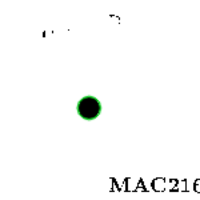

In [225]:
# Create a detector without the parameters
detector = cv2.SimpleBlobDetector_create()

# Detect blobs.
keypoints = detector.detect(quad[0])

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(quad[0], keypoints, np.array([]), (20,200,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
# cv2_imshow(im_with_keypoints)
cv2_imshow(cv2.resize(im_with_keypoints, (200, 200)))
# cv2.waitKey(0)

In [226]:
def SimpleBlobDetector(quad):
    keypoints = []
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 200

    # Filter by Area.
    params.filterByArea = True
    params.maxArea = 280
    params.minArea = 200

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = [detector.detect(q) for q in quad]
    return keypoints

In [227]:
# img_keypoints = cv2.drawKeypoints(img, keypoints[0], np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2_imshow(img_keypoints)

In [228]:
keypoints = SimpleBlobDetector(quad)
found, points, sizes = list_points(keypoints)
print("original points", points)
points = pre.mount(points)
print("Trasnformation", points) 
print("sizes",sizes)

original points [[66.33842468261719, 80.5], [70.81729888916016, 78.88888549804688], [66.24114990234375, 58.44247817993164], [72.3234634399414, 57.252288818359375]]
Trasnformation [(66.33842468261719, 80.5), (920.8172988891602, 78.88888549804688), (66.24114990234375, 1322.4424781799316), (922.3234634399414, 1321.2522888183594)]
sizes [17.2130126953125, 16.812278747558594, 17.06877899169922, 17.417381286621094]


[(286.79436609681454, 43.41555094040246), (470.5076506086457, 59.137990173042894), (286.79436609681454, 62.7695318436256), (470.5076506086457, 77.85111078145732)]
ocr [(604.6610723219363, 60.84695095919946), (724.2883273528962, 80.5)]
[(286.79436609681454, 43.41555094040246), (470.5076506086457, 59.137990173042894), (286.79436609681454, 62.7695318436256), (470.5076506086457, 77.85111078145732)]
62.7695318436256


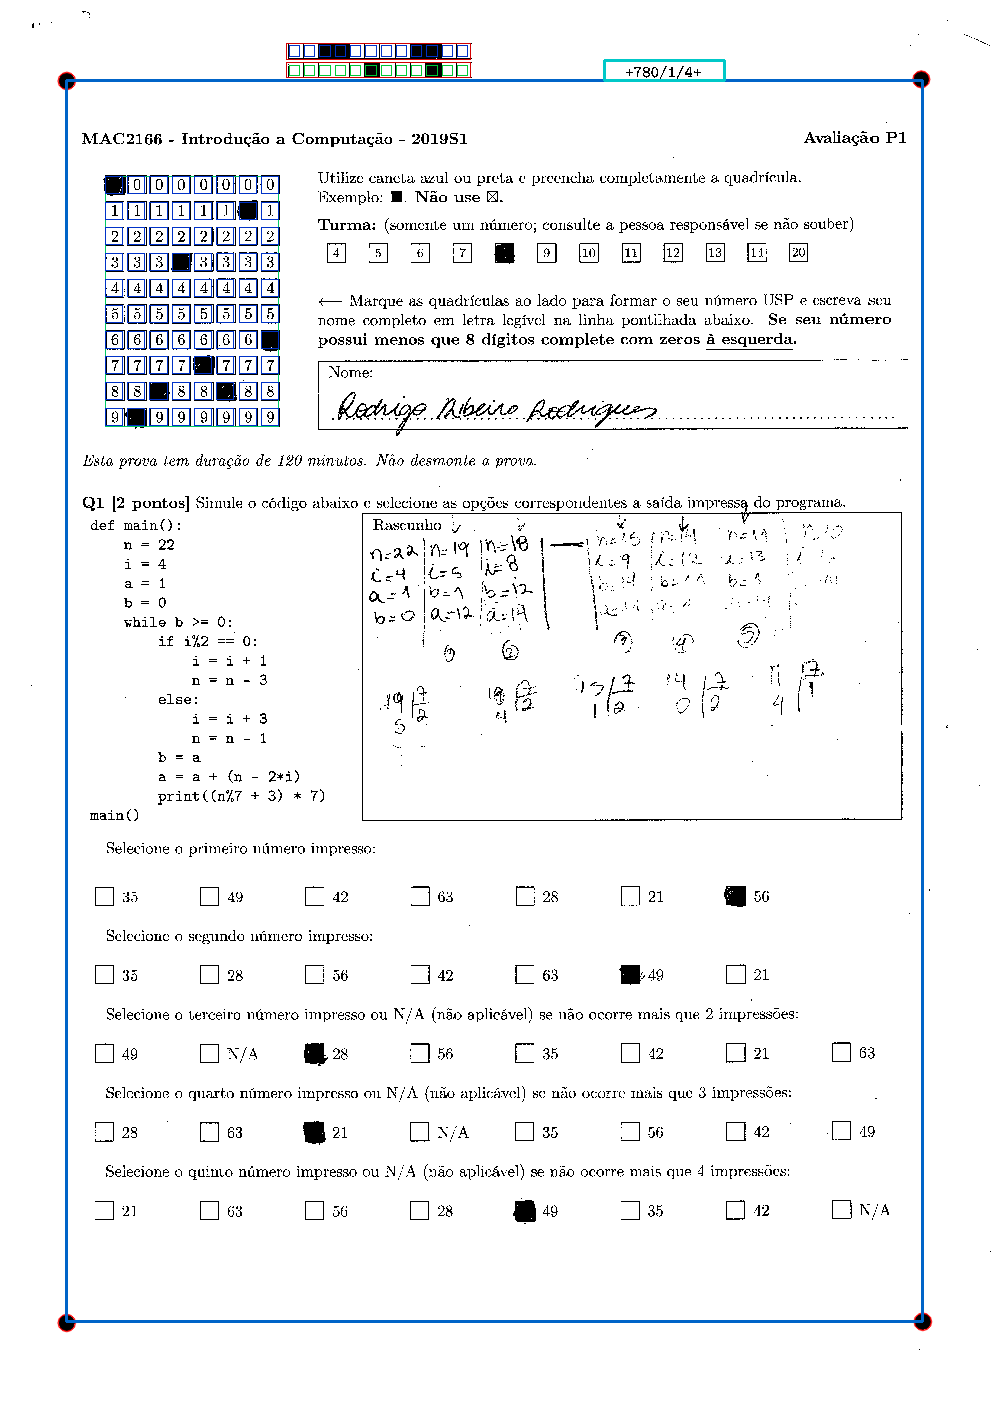

In [229]:
dist = distance(points)
img_rect = draw_rects(points, sizes, img)
pt_usp, img_rect = nusp_rect(dist[0], points[0], img_rect)
pt_code, img_rect = code_rect(dist[0], points[0], img_rect)

print(pt_code)
pt_ocr, img_rect = ocr_rect(dist[0], points[0], img_rect)
print("ocr", pt_ocr)
pt_sub_usp, img_rect = nusp_sub_rect(dist[0], pt_usp[0], img_rect)
pt_sub_code1, pt_sub_code2, img_rect = code_sub_rect(dist[0], pt_code, img_rect)
cv2_imshow(img_rect)

In [230]:
def recognize_code(pts):
    c=0
    # TO STORE THE NON ZERO VALUES OF EACH BOX
    myPixelVal = np.zeros(12) 
    for i in range(24):
        if i%2==0:
          idx = int(i/2)
          img_qd = image[int(pts[i][1]):int(pts[i+1][1]), int(pts[i][0]):int(pts[i+1][0])]
          totalPixels = cv2.countNonZero(img_qd)
          if totalPixels<50:
              myPixelVal[idx]= 1
    # print("myPixelVal reversed\n", myPixelVal[::-1])
    # print("myPixelVal\n", myPixelVal)
    return myPixelVal

def covert_binary_to_decimal(code):
    result = 0
    for i, n in enumerate(reversed(code)):
        # print(i,n)
        result += n*(2**i)
    return result

def val_code(test, page):
    code=60-((test-1)*4+(page-1))%60
    return code

def ocr_code(pt_ocr, img):

    crop_ocr = img[int(pt_ocr[0][1]):int(pt_ocr[1][1]), int(pt_ocr[0][0]):int(pt_ocr[1][0])].copy()

    extractedInformation = ocr.image_to_string(crop_ocr)
    # print(extractedInformation)
    test, page, code  = extractedInformation.split("+")[1].split("/")

    return test, page, code


In [231]:
test_ocr, page_ocr, code_ocr = ocr_code(pt_ocr, img)
print('OCR detection:')
print('test number: {}'.format(test_ocr))
print('page: {} code: {}'.format(page_ocr, code_ocr))

OCR detection:
test number: 780
page: 1 code: 4


In [232]:
code1 = recognize_code(pt_sub_code1)
code2 = recognize_code(pt_sub_code2)

test_blob = covert_binary_to_decimal(code1)
page_blob = covert_binary_to_decimal(code2[:6])
n_code_blob = covert_binary_to_decimal(code2[6:])

print("Blob detection:\nteste number: {}\npage: {} code: {}".format(test_blob, page_blob, n_code_blob))

Blob detection:
teste number: 780.0
page: 1.0 code: 4.0


In [233]:
v_code = val_code(test_blob, page_blob)
print("Validation code:\nteste number: {}\npage: {} code: {}".format(test_blob, page_blob, v_code))

Validation code:
teste number: 780.0
page: 1.0 code: 4.0
